# Dataset Description:
**Context**
This is the sentiment140 dataset. It contains 1,600,000 tweets extracted using the twitter api . The tweets have been annotated (0 = negative, 4 = positive) and they can be used to detect sentiment .

**Content**
It contains the following 6 fields:

**1. target**: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)

**2. ids:** The id of the tweet ( 2087)

**3. date:** the date of the tweet (Sat May 16 23:58:44 UTC 2009)

**4. flag:** The query (lyx). If there is no query, then this value is NO_QUERY.

**5. user:** the user that tweeted (robotickilldozr)

**6. text:** the text of the tweet (Lyx is cool)

In [2]:
import re
import nltk
import random
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D,GlobalAveragePooling1D, Concatenate, Dense, Dropout

from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('wordnet', "/kaggle/working/nltk_data/")
nltk.download('omw-1.4', "/kaggle/working/nltk_data/")
! unzip /kaggle/working/nltk_data/corpora/wordnet.zip -d /kaggle/working/nltk_data/corpora
! unzip /kaggle/working/nltk_data/corpora/omw-1.4.zip -d /kaggle/working/nltk_data/corpora

nltk.data.path.append("/kaggle/working/nltk_data/")

2024-05-18 20:06:47.087060: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-18 20:06:47.087170: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-18 20:06:47.215193: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /kaggle/working/nltk_data/...
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /kaggle/working/nltk_data/...
Archive:  /kaggle/working/nltk_data/corpora/wordnet.zip
   creating: /kaggle/working/nltk_data/corpora/wordnet/
  inflating: /kaggle/working/nltk_data/corpora/wordnet/lexnames  
  inflating: /kaggle/working/nltk_data/corpora/wordnet/data.verb  
  inflating: /kaggle/working/nltk_data/corpora/wordnet/index.adv  
  inflating: /kaggle/working/nltk_data/corpora/wordnet/adv.exc  
  inflating: /kaggle/working/nltk_data/corpora/wordnet/index.verb  
  inflating: /kag

### Load the dataset

In [3]:
df = pd.read_csv('/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv', encoding='ISO-8859-1', names=['target', 'id', 'date', 'flag', 'user', 'text'])
df

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


### Data Preprocessing

- Remove unnecessary columns

In [4]:
data = df[['text', 'target']]
data

,text,target
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,is upset that he can't update his Facebook by ...,0
2,@Kenichan I dived many times for the ball. Man...,0
3,my whole body feels itchy and like its on fire,0
4,"@nationwideclass no, it's not behaving at all....",0
...,...,...
1599995,Just woke up. Having no school is the best fee...,4
1599996,TheWDB.com - Very cool to hear old Walt interv...,4
1599997,Are you ready for your MoJo Makeover? Ask me f...,4
1599998,Happy 38th Birthday to my boo of alll time!!! ...,4


- Check if there are any rows where target is 2 (make sure all targets are 0 or 4)

In [5]:
target_2_data = data[data['target'] == 2]

if target_2_data.empty:
    print("No rows with target equal to 2")
else:
    print("Rows with target equal to 2 exist")

No rows with target equal to 2


- Convert target 4 to be 1

In [6]:
data.loc[data['target'] == 4, 'target'] = 1
print(data['target'].value_counts())

target
0    800000
1    800000
Name: count, dtype: int64


In [7]:
data

,text,target
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,is upset that he can't update his Facebook by ...,0
2,@Kenichan I dived many times for the ball. Man...,0
3,my whole body feels itchy and like its on fire,0
4,"@nationwideclass no, it's not behaving at all....",0
...,...,...
1599995,Just woke up. Having no school is the best fee...,1
1599996,TheWDB.com - Very cool to hear old Walt interv...,1
1599997,Are you ready for your MoJo Makeover? Ask me f...,1
1599998,Happy 38th Birthday to my boo of alll time!!! ...,1


- Preprocessing function to clean data

In [8]:
def preprocess(review):
    review = re.sub('[^a-zA-Z]', ' ',review)
    review = review.lower()
    
    review_minus_sw = []
    stop_words = stopwords.words('english')
    review = review.split()
    review = [review_minus_sw.append(word) for word in review if word not in stop_words]
    review = ' '.join(review_minus_sw)
    
    lemmatizer = WordNetLemmatizer()
    review = review.split()
    review = [lemmatizer.lemmatize(w) for w in review]
    review = ' '.join(review)
    
    return review

In [9]:
data.loc[:, 'text'] = data['text'].apply(preprocess)

In [10]:
data

,text,target
0,switchfoot http twitpic com zl awww bummer sho...,0
1,upset update facebook texting might cry result...,0
2,kenichan dived many time ball managed save res...,0
3,whole body feel itchy like fire,0
4,nationwideclass behaving mad see,0
...,...,...
1599995,woke school best feeling ever,1
1599996,thewdb com cool hear old walt interview http b...,1
1599997,ready mojo makeover ask detail,1
1599998,happy th birthday boo alll time tupac amaru sh...,1


- converting the text data into sequences of integers (where each integer represents a word) and ensures that all sequences have the same length by padding
- split the data into train, test

In [11]:
x = data['text'].values
y = data['target'].values

# Tokenization
max_words = 10000  
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(x)
x_seq = tokenizer.texts_to_sequences(x)

# Padding sequences
maxlen = 100  
x_pad = pad_sequences(x_seq, maxlen=maxlen)

x_train, x_test, y_train, y_test = train_test_split(x_pad, y, test_size=0.2, random_state=42)

In [12]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(1280000, 100)
(320000, 100)
(1280000,)
(320000,)


In [13]:
print(x_train[0])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0  171    7    4 2029 1137 2226   78  151    2
  651  128]


In [14]:
y_train

array([1, 1, 1, ..., 0, 0, 0])

In [15]:
word_embeddings = tokenizer.word_index
num_tokens = len(word_embeddings)
print('dataset has %s number of independent tokens' %num_tokens)

dataset has 573668 number of independent tokens


In [16]:
print("Sample from word_embeddings:")
sample = dict(list(word_embeddings.items())[:5])
print(sample)

Sample from word_embeddings:
{'day': 1, 'good': 2, 'get': 3, 'like': 4, 'go': 5}


In [17]:
embedding_dim = 100
vocab_size = len(tokenizer.word_index) + 1

## **Constant for all models:**

- The first layer is an embedding layer, which is responsible for converting integer-encoded vocabulary indices into dense vectors of fixed size (embedding_dim)
- vocab_size represents the size of the vocabulary (number of unique words) in dataset
- activation = relu for hidden layers
- activation = softmax for output layer
- optimizer = adam
- loss = sparse categorical crossentropy
- trained on 5 epochs and batch size = 64

### Model 0
- Conv (filters=2, kernel=3)
- MaxPooling

In [ ]:
model = Sequential([
        Embedding(vocab_size, embedding_dim),
        Conv1D(2, 3, activation='relu'),
        GlobalMaxPooling1D(),
        Dense(2, activation='softmax')])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=5, batch_size=64)

In [ ]:
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {accuracy*100:.3f} %")

In [ ]:
y_pred = model.predict(x_test)
print(y_pred)

y_pred = np.argmax(y_pred, axis=1)
print(y_pred)

In [ ]:
cm = confusion_matrix(y_test,y_pred)
ax = sns.heatmap(cm, annot=True, cmap='Blues',fmt=' ')
ax.set_title('Confusion Matrix')
ax.set_xlabel('y_test')
ax.set_ylabel('y_pred')

In [ ]:
print(classification_report(y_test,y_pred))

### Model 1
- Conv (filers=64, kernel=5)
- MaxPooling

In [ ]:
model1 = Sequential([
        Embedding(vocab_size, embedding_dim),
        Conv1D(64, 5, activation='relu'),
        GlobalMaxPooling1D(),
        Dense(2, activation='softmax')])

model1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history1 = model1.fit(x_train, y_train, epochs=5, batch_size=64)

In [ ]:
loss1, accuracy1 = model1.evaluate(x_test, y_test)
print(f"Test Accuracy: {accuracy1*100:.3f} %")

In [ ]:
y_pred1 = model1.predict(x_test)
print(y_pred1)
print()
y_pred1 = np.argmax(y_pred1, axis=1)
print(y_pred1)

In [ ]:
cm1 = confusion_matrix(y_test,y_pred1)
ax = sns.heatmap(cm1, annot=True, cmap='Blues',fmt=' ')
ax.set_title('Confusion Matrix')
ax.set_xlabel('y_test')
ax.set_ylabel('y_pred')

In [ ]:
print(classification_report(y_test,y_pred1))

### Model 2
- Conv (filters=128, kernel=5)
- MaxPooling

In [ ]:
model2 = Sequential([
        Embedding(vocab_size, embedding_dim),
        Conv1D(128, 5, activation='relu'),
        GlobalMaxPooling1D(),
        Dense(2, activation='softmax')])

model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history2 = model2.fit(x_train, y_train, epochs=5, batch_size=64)

In [ ]:
loss2, accuracy2 = model2.evaluate(x_test, y_test)
print(f"Test Accuracy: {accuracy2*100:.3f} %")

In [ ]:
y_pred2 = model2.predict(x_test)
print(y_pred2)
print()
y_pred2 = np.argmax(y_pred2, axis=1)
print(y_pred2)

In [ ]:
cm2 = confusion_matrix(y_test,y_pred2)
ax = sns.heatmap(cm2, annot=True, cmap='Blues',fmt=' ')
ax.set_title('Confusion Matrix')
ax.set_xlabel('y_test')
ax.set_ylabel('y_pred')

In [ ]:
print(classification_report(y_test,y_pred2))

### Model 3
- Conv (filters=128, kernel=5)
- AveragePooling

In [18]:
model3 = Sequential([
        Embedding(vocab_size, embedding_dim),
        Conv1D(128, 5, activation='relu'),
        GlobalAveragePooling1D(),
        Dense(2, activation='softmax')])

model3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history3 = model3.fit(x_train, y_train, epochs=5, batch_size=64)

Epoch 1/5
   18/20000 ━━━━━━━━━━━━━━━━━━━━ 3:18 10ms/step - accuracy: 0.5179 - loss: 0.6938

I0000 00:00:1716063230.696652     109 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


20000/20000 ━━━━━━━━━━━━━━━━━━━━ 198s 10ms/step - accuracy: 0.7503 - loss: 0.5021
Epoch 2/5
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 192s 10ms/step - accuracy: 0.7883 - loss: 0.4493
Epoch 3/5
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 192s 10ms/step - accuracy: 0.7966 - loss: 0.4350
Epoch 4/5
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 192s 10ms/step - accuracy: 0.8050 - loss: 0.4214
Epoch 5/5
20000/20000 ━━━━━━━━━━━━━━━━━━━━ 203s 10ms/step - accuracy: 0.8136 - loss: 0.4069


In [19]:
loss3, accuracy3 = model3.evaluate(x_test, y_test)
print(f"Test Accuracy: {accuracy3*100:.3f} %")

10000/10000 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - accuracy: 0.7827 - loss: 0.4676
Test Accuracy: 78.256 %


In [20]:
y_pred3 = model3.predict(x_test)
print(y_pred3)

y_pred3 = np.argmax(y_pred3, axis=1)
print(y_pred3)

10000/10000 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step
[[0.30131757 0.69868237]
 [0.06551698 0.934483  ]
 [0.16571379 0.8342863 ]
 ...
 [0.02177971 0.9782203 ]
 [0.82276195 0.17723797]
 [0.9206062  0.0793938 ]]
[1 1 1 ... 1 0 0]


Text(50.722222222222214, 0.5, 'y_pred')

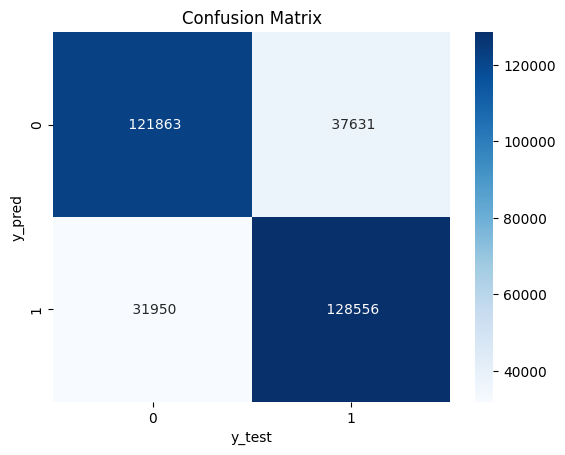

In [21]:
cm3 = confusion_matrix(y_test,y_pred3)
ax = sns.heatmap(cm3, annot=True, cmap='Blues',fmt=' ')
ax.set_title('Confusion Matrix')
ax.set_xlabel('y_test')
ax.set_ylabel('y_pred')

In [22]:
print(classification_report(y_test,y_pred3))

              precision    recall  f1-score   support

           0       0.79      0.76      0.78    159494
           1       0.77      0.80      0.79    160506

    accuracy                           0.78    320000
   macro avg       0.78      0.78      0.78    320000
weighted avg       0.78      0.78      0.78    320000



In [26]:
def print_random_predictions(x_test, y_test, y_pred, n=10):
    indices = random.sample(range(len(x_test)), n)
    for i in indices:
        print(f"Sentence: {tokenizer.sequences_to_texts([x_test[i]])[0]}")
        print(f"True label: {y_test[i]}, Predicted label: {y_pred[i]}\n")

# Print 10 random predictions
print_random_predictions(x_test, y_test, y_pred3)

Sentence: miss already
True label: 0, Predicted label: 0

Sentence: free ticket oh live south africa
True label: 0, Predicted label: 0

Sentence: family bbq alcohol sun good combination
True label: 1, Predicted label: 1

Sentence: good point backyard mechanic vibe lost
True label: 0, Predicted label: 0

Sentence: gone day girl state lunch working ape project night txt u wanna
True label: 0, Predicted label: 0

Sentence: awesome sunday service god jesus praying man
True label: 1, Predicted label: 1

Sentence: yeah aww stupid wks couldve done london
True label: 0, Predicted label: 0

Sentence: time quick breakfast shower maybe library time club
True label: 1, Predicted label: 1

Sentence: know rob accident right still girl look sad pic
True label: 0, Predicted label: 0

Sentence: tomorrow going school hate school
True label: 0, Predicted label: 0



### Model 4
- Conv (filters=2, kernel=3)
- MaxPooling
- Conv (filters=2, kernel=4)
- MaxPooling
- Conv (filters=2, kernel=5)
- MaxPooling

In [ ]:
filter_sizes = [3, 4, 5]
num_filters = 2
dropout_rate = 0.5

input_layer = Input(shape=(maxlen,))
embedding_layer = Embedding(vocab_size, embedding_dim)(input_layer)
conv_blocks = []

for filter_size in filter_sizes:
    conv = Conv1D(filters=num_filters, kernel_size=filter_size, activation='relu')(embedding_layer)
    conv = GlobalMaxPooling1D()(conv)
    conv_blocks.append(conv)

concat = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]
concat_dropout = Dropout(dropout_rate)(concat)
output_layer = Dense(2, activation='softmax')(concat_dropout)

model4 = Model(inputs=input_layer, outputs=output_layer)
model4.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history4 = model4.fit(x_train, y_train, epochs=5, batch_size=64)

In [ ]:
loss4, accuracy4 = model4.evaluate(x_test, y_test)
print(f"Test Accuracy: {accuracy4*100:.3f} %")

In [ ]:
y_pred4 = model4.predict(x_test)
print(y_pred4)

y_pred4 = np.argmax(y_pred4, axis=1)
print(y_pred4)

In [ ]:
cm4 = confusion_matrix(y_test,y_pred4)
ax = sns.heatmap(cm4, annot=True, cmap='Blues',fmt=' ')
ax.set_title('Confusion Matrix')
ax.set_xlabel('y_test')
ax.set_ylabel('y_pred')

In [ ]:
print(classification_report(y_test,y_pred4))